<DIV ALIGN=CENTER>

# Introduction to Density Estimation
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we explore how to represent data by using a
density estimate; the most simple example of which is the histogram.
After reviewing the advantages and disadvantages of using a histogram,
we introduce the kernel density estimate and demonstrate how this can be
used to model a data set. While a density estimate can be an important
visualization tool, they are often used to create probabilistic models
of the underlying data distribution, and as such, can be used to
generate new samples for further analysis. We perform density estimation
on the Iris and hand-written digit data used in previous Notebooks.
First, we will setup this Notebook, and introduce the Iris data, before
performing density estimation on this data

-----

In [13]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

# Load the Iris Data
iris = sns.load_dataset("iris")

-----

## Iris Data

We will use the standard Iris classification data set to explore density
estimation, in this Notebook. The four primary dimensions of the data
include Sepal Length, Sepal Width, Petal Length, and Petal Width, which
can be seen from the following Iris picture (or type _virginica_).

![Iris picture from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/220px-Iris_virginica.jpg)

The data set consists of 150 total measurements of three different types
of Iris flowers, equally divided between three classes: Iris Setosa,
Iris versicolor, and Iris virginica. To get started, we will pick one
dimension (or feature) in the data set and explore the distribution of
the values in this dimension. For simplicity, we will select the _Sepal
Length_ feature. On its own, we simply have 150 measurements of this
feature. These measurements can be used to visualize the distribution or
they could be used to build a predictive model by assuming that they are
samples drawn from the parent distribution for this feature (which in
general would be an unknown function).

As a first step, we can simply plot the one-dimensional distribution.
Rather than simply plotting the points themselves, it is customary to
plot short lines at each location of the points. This type of plot is
known as a **rug plot** due to its similarity to a carpet with the
points appearing like carpet fibers. In the following cell, we plot the
_Sepal Length_ feature as a rug plot. However, since some measurements
have the same value, the initial plot does not represent the full data
set. Thus, in the second plot, we add a random _jitter_ to each point to
more clearly indicate locations where the density of points is higher.

-----


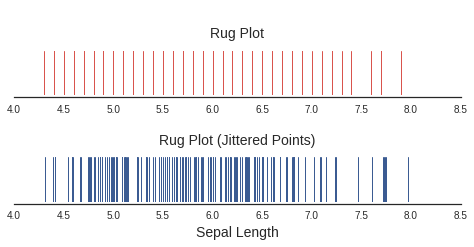

In [3]:
# We make our own rug plots, wrapping seaborn calls.
# One plot needs jittered ppints.
jitter = 0.05

# Colect our two data sets
data = []
data.append(iris['sepal_length'])
data.append(iris['sepal_length'] + np.random.normal(0, jitter, len(data[0])))

# Make the plots
fig, axs = plt.subplots(figsize=(8, 3.5), nrows=2, ncols=1, sharex=True)

# Set plot colors and titles
clr = [sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]]
ttl = ['Rug Plot', 'Rug Plot (Jittered Points)']

# MMake each subplot
for idx, dat in enumerate(data):
    sns.rugplot(ax = axs[idx], a=dat, height=0.5, c = clr[idx])
    axs[idx].set_yticks([])
    axs[idx].set_xlim(4.0, 8.5)
    axs[idx].set_xlabel('Sepal Length', fontsize=14)
    axs[idx].text(6.25, 0.65, ttl[idx], ha='center', fontsize=14)
    sns.despine(ax=axs[idx], left=True, offset=2, trim=True)

plt.show()

-----
## Histograms

While useful, especially with the added jitter, the standard method for
visualizing the one-dimensional distribution of points is the
histogram. A [histogram][wh] counts the number of points that lie within
bins that are spaced along the dimension of interest. If the histogram
is normalized, the distribution can generally be considered an estimate
of the likelihood or probability of a given value being drawn from the
distribution.

There are two primary components in computing a histogram from a set of
data points:

1. How many bins should be used?
2. Where should the bins be placed

The primary choice is simply how many bins should be used to model the
density of points. Using more bins can capture more detail, but is also
susceptible to noise. The spacing of the bins can often be left to the
visualizing software. In the following cell, we compare the visual
distribution of two histograms based on the same Iris _Sepal Length_
features, where only the number of bins used for the histograms has been
changed, from ten to twenty.

-----

[wh]: https://en.wikipedia.org/wiki/Histogram

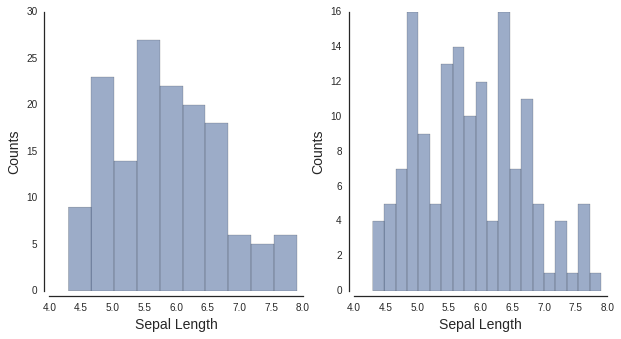

In [4]:
# Make comparative histograms, two different binning strategies
nbs = [10, 20]

# Make plots
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

for ax, nb in zip(axs, nbs):
    ax.hist(iris['sepal_length'], bins=nb, alpha=0.5, color=sns.xkcd_rgb["denim blue"])
    ax.set_xlabel('Sepal Length', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    sns.despine(ax=ax, offset=5, trim=True)

plt.show()

-----

In the previous figure, increasing the number of bins makes the
resulting histogram more sensitive to fluctuations in the data. In some
cases, this might be important, but often, especially in relatively
smaller data sets, this simply captures the _noise_ in the sample. A
second problem with the histogram is that, even when normalized, we do
not have a simple, reliable means to sample from the distribution. 

As we mentioned previously, the histogram produces a binned density
estimate, which when normalized can often be treated as a [probability
mass (or density) distribution][wpd]. Sampling directly from a histogram
is acceptable for discrete data (like flipping a coin or drawing cards
from a deck), but for continuous functions the lack of fidelity in a
histogram caused by the bin width hinders the application of this
technique. In addition, if one wishes to use this distribution in a
calculation, the histogram will inherently limit the precision of any
calculation. 

As a result, we often require a functional approximation to the density.
In the following figure, we demonstrate the problem with using the
histogram itself to directly estimate this function, by simply
connecting the binned quantities (with the red line, which is a simple
linear interpolation). While this line does capture the fluctuations in
the data, it is not smoothly varying and is also clearly dependent on
the binning strategy used to create the histogram.

-----

[wpd]: https://en.wikipedia.org/wiki/Probability_distribution

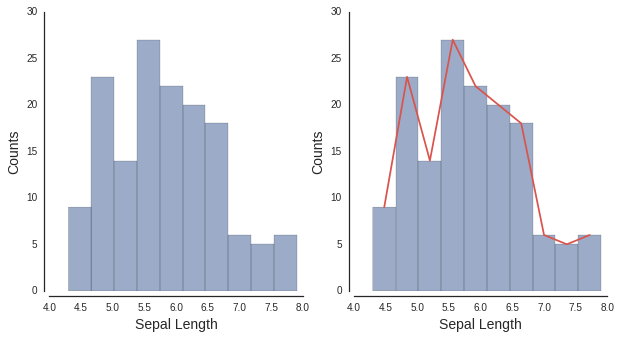

In [5]:
# Comparative histograms, same number of bins, connect bins centers in one.
nb = 10

# Make plot
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

for idx, ax in enumerate(axs):
    
    # Make histogram, but grab output values to later connect bins
    n, bins, patches = ax.hist(iris['sepal_length'], bins=nb, \
                               alpha=0.5, color=sns.xkcd_rgb["denim blue"])
    ax.set_xlabel('Sepal Length', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    
    # Connect bin centers for second plot
    if idx:
        bc = bins[:-1] + (bins[1] - bins[0])/2.0
        ax.plot(bc, n, c=sns.xkcd_rgb["pale red"])

    sns.despine(ax=ax, offset=5, trim=True)

plt.show()

-----

## Kernel Density Estimation

As the preceding figure demonstrates, simply interpolating between the
bin centers (even if a more sophisticated interpolation strategy is
used) fails to capture the parent distribution of a set of features. As
a result, more sophisticated techniques have been developed to
functionally estimate the density of points. The most popular technique
is known as [kernel density estimation][wkde] or KDE, which simply
**replaces each point by a function (or kernel)** and accumulates the kernel
contributions into a final functional form. The end result is generally
normalized, creating a probability distribution for the data. Simply
put, KDE works by replacing each discrete point by an approximating,
continuous function.

The choice of kernel function clearly has an important impact on the
functional representation, and ideally has some physical motivation. The
most popular kernel is the Gaussian, or normal, which is often
appropriate given the nature of many sampling processes (where the
errors on a measurement are normally distributed). Once a kernel
function has been selected, the parameters of the kernel function will
also ned to be selected. Generally the most important kernel function
parameter is the bandwidth, which controls the _width_ the kernel
function. This parameter acts in a similar manner as the bin width of a
histogram, too wide and the fluctuations in the data set are smoothed
over, too fine and the (possible noise) fluctuations can overwhelm the
signal.

If we simply want to create a KDE for visualization purposed, we can use
Seaborn to [plot a KDE][skde] over a histogram, with an option to include the
rug plot as well. This is demonstrated in the following figure, where we
generate a KDE for our Iris _Sepal Length_ features, overplotting the
KDE on the histogram. Notice how the KDE estimate more closely
approximates the underlying histogram than our previous interpolation.

-----
[wkde]: https://en.wikipedia.org/wiki/Kernel_density_estimation
[skde]: http://stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html#kernel-density-estimaton

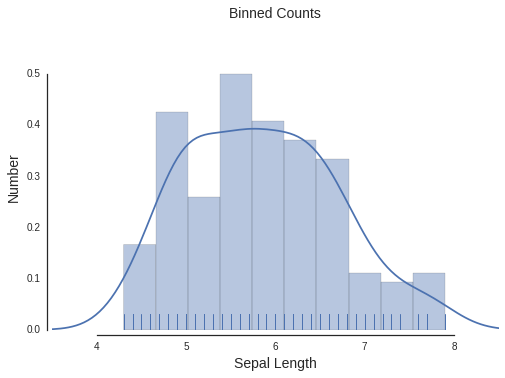

In [7]:
# Use Seaborn to make a KDE over histogram.
# Add in a rug plot for good measure.
ax = sns.distplot(iris['sepal_length'], kde=True, rug=True, bins=10)
ax.set_xlim(3.5, 8.5)
ax.set_ylim(0, 0.6)
ax.set_xlabel('Sepal Length', fontsize=14)
ax.set_ylabel('Number', fontsize=14)
ax.set_title('Binned Counts', fontsize=14)
sns.despine(offset=5, trim=True)

-----

While the KDE representation above clearly approximates the underlying
data, it isn't clear how the KDE was itself constructed. Since the
process is actually quite simple, in the following code cell we actually
estimate the KDE by simply using Python (note that this example was
drawn from a similar analysis performed in the Seaborn documentation).
We first compute a bandwidth. In this case we derive one based on the
density of points, however, we could simply estimate value. Net, we
construct our support, or the space over which we will sample our kernel
functions. Next, we create Gaussian kernels and sample them over our
support. 

As shown in the following figure, the density of kernel functions
follows the density of points. This is more easily sen since we changed
the `alpha` parameter, which controls the transparency of the plot
figures, so that when multiple kernel functions overlap the plot becomes
bolder. As a result, we can visually see the mapping between the density
of kernel functions and the density of points. The width of the kernel
(or in the is case Gaussian) functions is controlled by the bandwidth,
and the kernel functions themselves are normalized to have unit area.


-----

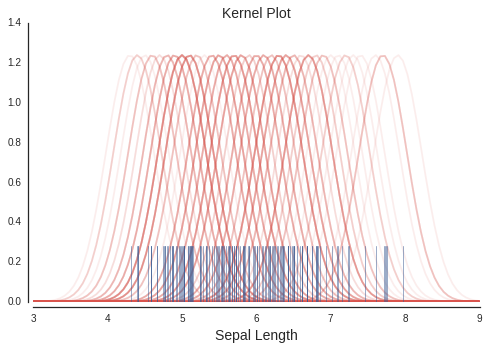

In [9]:
# KDE demonstration
# Modified from Seaborn documentation

from scipy import stats, integrate

# For kernel Density Estimation, 
# we need a Kernel model and a bandwidth.
# Here we assume a Gaussian Kernel, and the Seaborn bandwidth.

dt = data[0]
bw = 1.06 * dt.std() * len(dt) ** (-1 / 5.)
support = np.linspace(3, 9, 100)

# Make the plot
fig, ax = plt.subplots(figsize=(8, 5))

# We construct and plot a Gaussian over each 'rug fiber'
kernels = []
for d in dt:
    kernel = stats.norm(d, bw).pdf(support)
    kernels.append(kernel)
    plt.plot(support, kernel, color=sns.xkcd_rgb["pale red"], alpha = 0.1)

# Now show rugplot as support.
sns.rugplot(data[1], color=sns.xkcd_rgb["denim blue"], \
            height=0.2, linewidth=1, alpha = 0.5)
plt.xlabel('Sepal Length', fontsize=14)
plt.title('Kernel Plot', fontsize=14)

sns.despine(offset=5, trim=True)
plt.show()

-----

Given these kernel functions (in this case we have 150 kernel functions,
one for each Iris in the data set), we can combine them together to make
the kernel density estimate. In the following code cell, we sum the
kernels together, and normalize by the total area to generate the KDE.
We subsequently plot this new kernel density estimate, over a rug plot
of the jittered data to demonstrate that this KDE is equivalent to the
Seaborn produced KDE.

An important distinction, however, is that we now have programmatically
created this KDE and can use the function in subsequent code to perform
additional computations.


-----

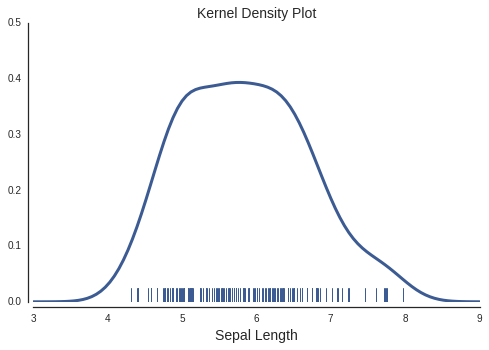

In [10]:
# Now combine the Guassian kernels into a a KDE

# To compute kernel density estimate, we sum up the individual kernels and 
# normalize by total area.
density = np.sum(kernels, axis=0)
density /= integrate.trapz(density, support)

# Make the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the KDE
plt.plot(support, density, color=sns.xkcd_rgb["denim blue"], linewidth=3)
plt.ylim(0.0, 0.5)

# Now show rugplot as support.
sns.rugplot(data[1], color=sns.xkcd_rgb["denim blue"], linewidth=1)
plt.xlabel('Sepal Length', fontsize=14)
plt.title('Kernel Density Plot', fontsize=14)

sns.despine(offset=5, trim=True)
plt.show()

-----

## Scikit Learn KDE

While we can compute a KDE on our own, the scikit learn library provides
a [kernel density estimation][skkde] implementation that is easy to use,
flexible, and scalable to large data. Given our previous experience with
this library, using a KDE in scikit learn will be familiar. We simply
import the KDE estimator, create the estimator with appropriate
parameters, and fit the estimator with the data. The estimator can be
used as a function, passing in [independent variables][wid] (i.e., $x$)
generates values for the dependent variables (i.e., $y$). 

In the following code cell, we use scikit learn to generate a KDE for
our Iris Sepal Length_ features. In the first example, we use the same
bandwidth calculated in the Seaborn example, which ensures we will
create the same KDE. Note that we create the KDE estimator, and sample
this function across the support in order to plot the function. In the
second code cell, we sample from this function to simply extract
estimates from our new model representation.

-----

[skkde]: http://scikit-learn.org/stable/modules/density.html
[wid]: https://en.wikipedia.org/wiki/Dependent_and_independent_variables

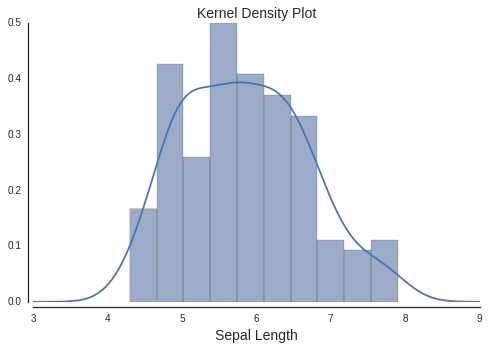

In [11]:
# Now repeat the process by using scikit learn
from sklearn.neighbors import KernelDensity

# Gaussian KDE with Seaborn bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=bw)

# Grab the data, and compute the support (sampling points)
x = iris['sepal_length']
support = np.linspace(3, 9, len(x))

# Create the KDE, and return the support values.
kde.fit(x[:, np.newaxis])
y = kde.score_samples(support[:, np.newaxis])

# Plot thje results including underlying histogram
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(x, bins=10, alpha=0.5, color=sns.xkcd_rgb["denim blue"], normed=True)
ax.plot(support, np.exp(y))
plt.xlabel('Sepal Length', fontsize=14)
plt.title('Kernel Density Plot', fontsize=14)

sns.despine(offset=5, trim=True)
plt.show()

In [14]:
# We can now sample from the scikit learn KDE model
for val in kde.sample(n_samples=15):
    print('{0:4.1f}, '.format(val[0]), end='')

 6.3,  6.6,  6.3,  5.5,  6.7,  6.2,  4.5,  6.9,  5.2,  6.6,  6.8,  4.6,  4.7,  4.7,  5.0, 

----

### Bandwidth Selection

Given the choice of a kernel function, which is commonly just the
Gaussian kernel, the next most important decision is the bandwidth. To
this point, we have used the Seaborn default value, but as with any
machine learning technique, we can vary this parameter and produce
(sometimes dramatically) different results. In the following code cell,
we generate multiple KDEs for the same data set by simply varying the
bandwidth. Notice how, in the same manner as a histogram, smaller
bandwidths can be affected any fluctuations in the data while larger
bandwidths can overly smooth features in the data, thus demonstrating
the importance of selecting this parameter appropriately.

----

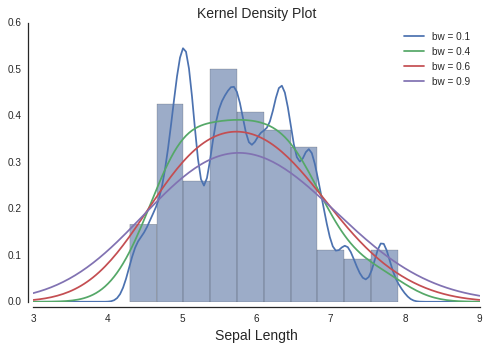

In [15]:
# Compare the impact of bandwidth selection on a KDE
from sklearn.neighbors import KernelDensity

# Make plots
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(x, bins=10, alpha=0.5, color=sns.xkcd_rgb["denim blue"], normed=True, label='')

# Gaussian KDE with varying bandwidths
for bw in np.linspace(0.1, 0.9, 4):
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(x[:, np.newaxis])
    y = kde.score_samples(support[:, np.newaxis])
    ax.plot(support, np.exp(y), label='bw = {0:3.1f}'.format(bw))

# Decorate plot
plt.xlabel('Sepal Length', fontsize=14)
plt.title('Kernel Density Plot', fontsize=14)
plt.legend()

sns.despine(offset=5, trim=True)
plt.show()

-----

## Student Activity

In the preceding cells, we created a kernel density estimator for the
Iris data. Now that you have run this Notebook once, go back and make
the following changes to see how the results change.

1. Change the dimension use in the one-dimensional KDE examples to one
of the other Iris features, such as _Petal Width_ or _Petal Length_ and
visualize the results.
2. Change the kernel function, when using scikit learn, to one of the
other [kernels][skf]. How do the results change?

[skf]: http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

----

## Multi-Variate KDE

To this point, we have performed density estimation in a single
dimension. Often, however, we will be working with multi-variate
datasets and wish to compute a density estimation in more than one
dimension. The KDE technique, however, can be easily extended to
additional dimensions. To demonstrate both the need and application of
density estimation in more than one dimension, we now switch to a
visualization of both the Iris data _Sepal Length_ and _Sepal Width_. In
the following figure, we display a joint plot of these two features by
using Seaborn's `jointplot` function. This plot shows the points and one
the horizontal and vertical axes displays the one dimensional histogram
of the features.

-----

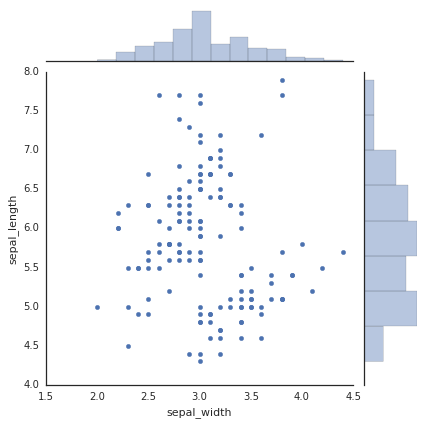

In [11]:
# Plot two-dimension data.
# A Seaborn jointplot has histograms and scatter points

ax = sns.jointplot(x='sepal_width', y='sepal_length', data=iris, stat_func=None)

-----

While this plot provides a visual representation of the underlying data,
we face the same issues as before. Both histograms are binned quantities
and the scatter plot can be overwhelmed by data points making a visual
understanding of the density difficult. To clarify these points, we can
generate both one-dimensional KDEs for the density distributions in each
dimension as well as a two-dimensional KDE for the joint data
distribution. To make a higher order KDE, we simply use higher order
kernel functions (e.g., a two-dimensional Gaussian kernel function). The
following figure demonstrates the use of a two-dimensional KDE to better
represent the underlying data. This technique is a popular method to
overplot discrete events over other data, such as weather events over
maps.

-----

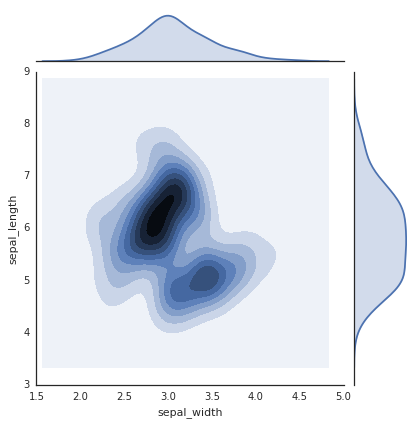

In [12]:
# Plot two-dimension data using a Seaborn jointplot, which 
# can show 1D and 2D KDE plots, for both joint distribution and each dimension

ax = sns.jointplot(x='sepal_width', y='sepal_length', data=iris, kind='kde', stat_func=None)

## Handwritten Digits

We now switch to a different data set, and application of density
estimation. We can make a density estimate of the handwritten digit data
set to create new _fake digit_ data (this example was drawn from the
[scikit-learn documentation][sk-kde]). This is an example of using the
density estimate as a model for the underlying data, and subsequently
sampling from this model to create and use new data. In the following
code cell, we load the data and review several digit images. 

-----
[sk-kde]: http://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html#example-neighbors-plot-digits-kde-sampling-py

Total number of samples = 1797


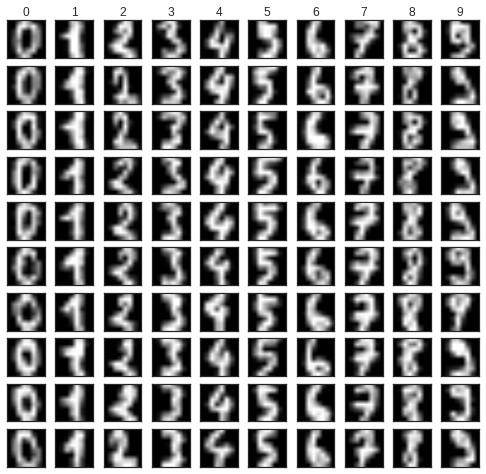

In [16]:
# We have helper code to assist in the loading and plotting of these data
import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()
hd.im_plot(x, y, images)

print('Total number of samples = {0}'.format(y.shape[0]))

-----

Now that we have the digit data loaded into this Notebook, we can
construct our density estimate. First, however, we apply a PCA
transformation to reduce the dimensionality of the data (the original
data is sixty-four dimensions, most of which provide little information
as we saw in the [Introduction to Dimensional Reduction][l1] Notebook).
In this case, by default we choose twenty dimensions, transform our
digit data to the new space, and compute a kernel density estimate. 
Given this new model representation of our data, we can sample from the
model to create new digit images. Before visualizing the new images,
however, we must transform the new data back into the full sixty-four
dimension space (so that we have an 8x8 pixel image). As the cell output
demonstrates, this simple model can quite easily generate realistic new
digit data.

-----

[l1]: intro2dr.ipynb

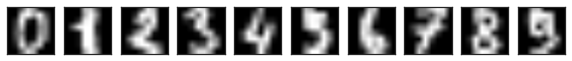

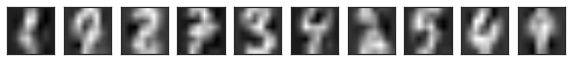

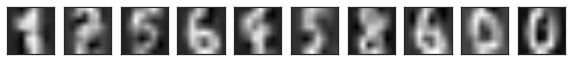

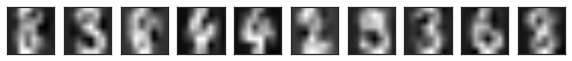

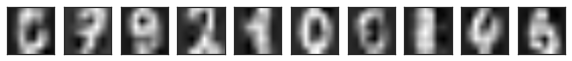

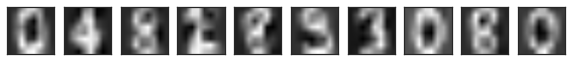

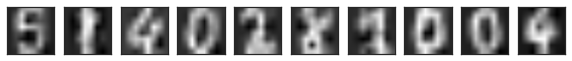

In [17]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# Testing parameters
ncps = 20
bw = 4.0 # Could do grid search to determine
nimgs = 60 # Multiple of ten

# Compute PCA for digit data
pca = PCA(n_components=ncps, copy=True)
data = pca.fit_transform(x)

# Compute KDE for PCAs
kde = KernelDensity(bandwidth=3)
kde.fit(data)

# Sample from model, and recover full image
new_data = kde.sample(nimgs, random_state=42)
new_data = pca.inverse_transform(new_data)

# Plot input data
hd.plot_numbers(x[:10])

for idx in range(0, nimgs, 10):
    hd.plot_numbers(new_data[0 + idx:10 + idx])

-----

## Student Activity

In the preceding cells, we used Kernel Density Estimation to build a
model representation of the digit data and to subsequently sample from
this model to make new digit images. Now that you have run the Notebook,
go back and make the following changes to see how the results change.

1. Change the number of PCA components lower and higher. How does this
affect the fidelity of the new digit images?
2. Change the bandwidth used in the KDE estimator. How does this affect
the fidelity of the new digit images?
3. Try using a different kernel function, for example a `exponential` or
`epanechnikov`. How does this affect the fidelity of the new digit images?

Finally, try applying a classifier on the new digit data. Can you
explain (feel free to use the class forums) why the classification
algorithm performed in the  manner it did for the new _fake_ digits?

-----